In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [35]:
# 生の文字列を使ってファイルパスを指定
file_path = r'C:\Users\nakan\Programing\.gpt\rawdata_carrot.csv'

# Excelファイルを読み込む
df = pd.read_csv(file_path)

# データの確認
print(df.tail())
print(df.info())

      ID  SEX  AGE  No2_Expensive  No2_Cheap  No2_TooExpensive  No2_TooCheap  \
182  216    1   10             60         20                80            10   
183  217    1   11             50         10                50             1   
184  218    1    8             50         30                80            20   
185  219    1    7            100         30               100            10   
186  220    2    3            130         50               150            30   

     No3_Expensive  No3_Cheap  No3_TooExpensive  ...  No8_Cheap  \
182             50         20                60  ...         10   
183             20         10                50  ...         10   
184             40         20                50  ...         70   
185             50         20                90  ...         30   
186            130         50               150  ...         30   

     No8_TooExpensive  No8_TooCheap  Shopping_frequency  Cooking_Frequency  \
182                60             5   

In [17]:
def PSM(df, Number):
    # 各質問に対する列名の定義
    too_cheap_col = f'No{Number}_TooCheap'
    too_expensive_col = f'No{Number}_TooExpensive'
    cheap_col = f'No{Number}_Cheap'
    expensive_col = f'No{Number}_Expensive'

    # データをソート
    df_sorted = df.sort_values(by=[too_cheap_col, too_expensive_col, cheap_col, expensive_col])

    # 価格の範囲を設定（0円から最大値まで1円刻み）
    price_range = np.arange(0, df_sorted[[too_cheap_col, too_expensive_col, cheap_col, expensive_col]].max().max() + 1, 1)

    # 各価格ポイントでの累積分布を計算
    too_cheap_cdf = np.array([(df_sorted[too_cheap_col] >= price).mean() for price in price_range])
    too_expensive_cdf = np.array([(df_sorted[too_expensive_col] <= price).mean() for price in price_range])
    cheap_cdf = np.array([(df_sorted[cheap_col] >= price).mean() for price in price_range])
    expensive_cdf = np.array([(df_sorted[expensive_col] <= price).mean() for price in price_range])

    # 線形補間関数を作成
    f_too_cheap = interp1d(price_range, too_cheap_cdf, bounds_error=False, fill_value="extrapolate")
    f_cheap = interp1d(price_range, cheap_cdf, bounds_error=False, fill_value="extrapolate")
    f_expensive = interp1d(price_range, expensive_cdf, bounds_error=False, fill_value="extrapolate")
    f_too_expensive = interp1d(price_range, too_expensive_cdf, bounds_error=False, fill_value="extrapolate")

    # 交点を見つけるための関数
    def find_intersection(func1, func2, x_range):
        differences = np.abs(func1(x_range) - func2(x_range))
        min_diff_index = np.argmin(differences)
        return x_range[min_diff_index], (func1(x_range[min_diff_index]) + func2(x_range[min_diff_index])) / 2

    # 交点を計算
    too_expensive_vs_cheap, too_expensive_vs_cheap_y = find_intersection(f_too_expensive, f_cheap, price_range)
    expensive_vs_cheap, expensive_vs_cheap_y = find_intersection(f_expensive, f_cheap, price_range)
    too_expensive_vs_too_cheap, too_expensive_vs_too_cheap_y = find_intersection(f_too_expensive, f_too_cheap, price_range)
    expensive_vs_too_cheap, expensive_vs_too_cheap_y = find_intersection(f_expensive, f_too_cheap, price_range)

    # 結果の表示
    print(f"IPP: {expensive_vs_cheap}")
    print(f"OPP: {too_expensive_vs_too_cheap}")
    print(f"HAP: {too_expensive_vs_cheap}")
    print(f"LAP: {expensive_vs_too_cheap}")

    # 累積分布の集計表を作成
    cumulative_df = pd.DataFrame({
        'Price': price_range,
        'Too_Cheap_CDF': too_cheap_cdf,
        'Too_Expensive_CDF': too_expensive_cdf,
        'Cheap_CDF': cheap_cdf,
        'Expensive_CDF': expensive_cdf
    })
    
    # 累積分布の集計表を表示
    print(cumulative_df)

    # プロットの作成
    plt.figure(figsize=(10, 6))
    plt.plot(price_range, too_cheap_cdf, label='Too Cheap')
    plt.plot(price_range, cheap_cdf, label='Cheap')
    plt.plot(price_range, expensive_cdf, label='Expensive')
    plt.plot(price_range, too_expensive_cdf, label='Too Expensive')

    # 交点をプロット
    plt.scatter([too_expensive_vs_cheap], [too_expensive_vs_cheap_y], color='red', label='HAP', zorder=5)
    plt.scatter([expensive_vs_cheap], [expensive_vs_cheap_y], color='green', label='IPP', zorder=5)
    plt.scatter([too_expensive_vs_too_cheap], [too_expensive_vs_too_cheap_y], color='blue', label='OPP', zorder=5)
    plt.scatter([expensive_vs_too_cheap], [expensive_vs_too_cheap_y], color='purple', label='LAP', zorder=5)

    # プロットの装飾
    plt.xlabel('Price')
    plt.ylabel('Cumulative Distribution')
    plt.title('Price Sensitivity Meter (PSM) Analysis')
    plt.legend()
    plt.grid(True)

    # プロットの表示
    plt.show()

IPP: 60
OPP: 51
HAP: 70
LAP: 50
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.000000   1.000000       0.005348
1        1       0.973262           0.000000   0.994652       0.005348
2        2       0.941176           0.000000   0.994652       0.005348
3        3       0.941176           0.000000   0.994652       0.005348
4        4       0.930481           0.000000   0.994652       0.005348
..     ...            ...                ...        ...            ...
346    346       0.000000           0.994652   0.000000       1.000000
347    347       0.000000           0.994652   0.000000       1.000000
348    348       0.000000           0.994652   0.000000       1.000000
349    349       0.000000           0.994652   0.000000       1.000000
350    350       0.000000           1.000000   0.000000       1.000000

[351 rows x 5 columns]


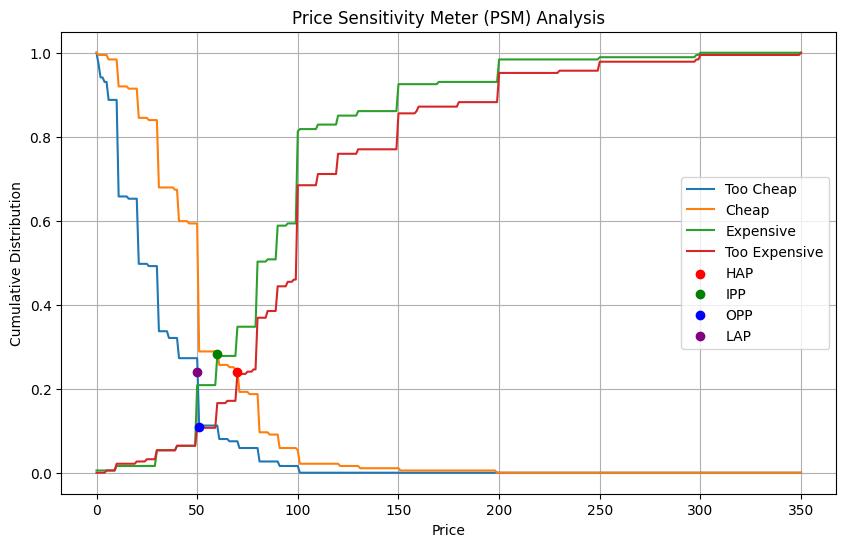

In [36]:
PSM(df,2)

IPP: 60
OPP: 51
HAP: 65
LAP: 50
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000                0.0   1.000000       0.005348
1        1       0.967914                0.0   0.978610       0.005348
2        2       0.925134                0.0   0.978610       0.005348
3        3       0.919786                0.0   0.978610       0.005348
4        4       0.914439                0.0   0.967914       0.005348
..     ...            ...                ...        ...            ...
394    394       0.000000                1.0   0.000000       0.994652
395    395       0.000000                1.0   0.000000       0.994652
396    396       0.000000                1.0   0.000000       0.994652
397    397       0.000000                1.0   0.000000       0.994652
398    398       0.000000                1.0   0.000000       1.000000

[399 rows x 5 columns]


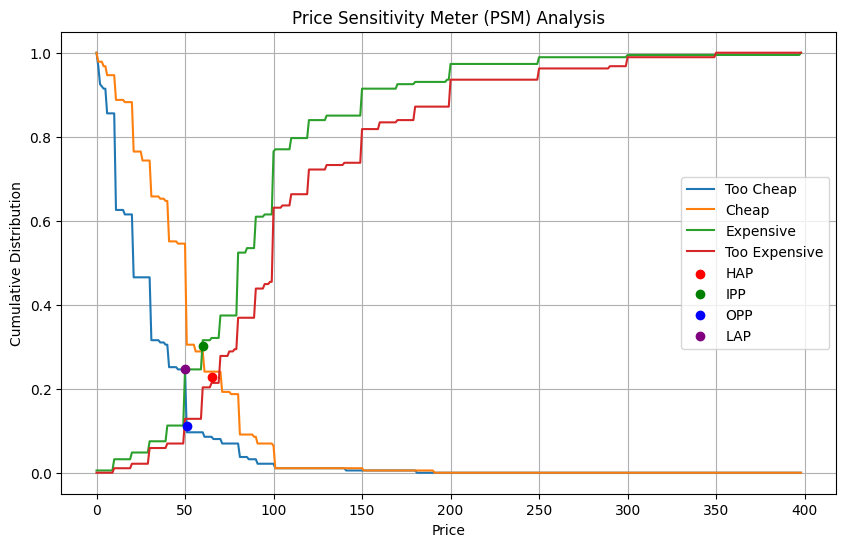

In [37]:
PSM(df,3)

IPP: 71
OPP: 60
HAP: 71
LAP: 51
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.000000   1.000000            0.0
1        1       0.973262           0.000000   0.994652            0.0
2        2       0.946524           0.000000   0.994652            0.0
3        3       0.941176           0.000000   0.994652            0.0
4        4       0.935829           0.000000   0.994652            0.0
..     ...            ...                ...        ...            ...
346    346       0.000000           0.994652   0.000000            1.0
347    347       0.000000           0.994652   0.000000            1.0
348    348       0.000000           0.994652   0.000000            1.0
349    349       0.000000           0.994652   0.000000            1.0
350    350       0.000000           1.000000   0.000000            1.0

[351 rows x 5 columns]


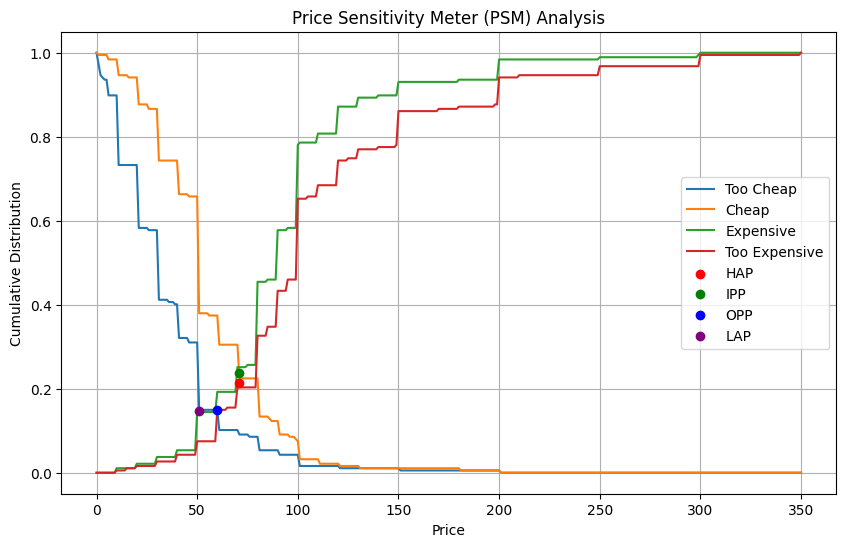

In [38]:
PSM(df,4)

IPP: 70
OPP: 51
HAP: 75
LAP: 51
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.000000        1.0            0.0
1        1       0.973262           0.000000        1.0            0.0
2        2       0.941176           0.000000        1.0            0.0
3        3       0.935829           0.000000        1.0            0.0
4        4       0.935829           0.000000        1.0            0.0
..     ...            ...                ...        ...            ...
346    346       0.000000           0.983957        0.0            1.0
347    347       0.000000           0.983957        0.0            1.0
348    348       0.000000           0.983957        0.0            1.0
349    349       0.000000           0.983957        0.0            1.0
350    350       0.000000           1.000000        0.0            1.0

[351 rows x 5 columns]


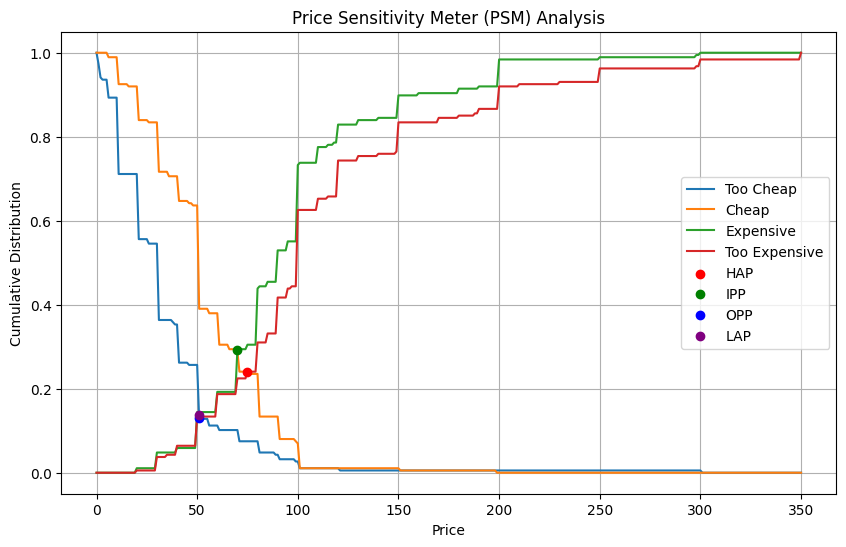

In [39]:
PSM(df,5)

IPP: 70
OPP: 60
HAP: 71
LAP: 51
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.000000   1.000000            0.0
1        1       0.967914           0.000000   0.989305            0.0
2        2       0.941176           0.000000   0.989305            0.0
3        3       0.935829           0.000000   0.989305            0.0
4        4       0.935829           0.000000   0.989305            0.0
..     ...            ...                ...        ...            ...
496    496       0.000000           0.994652   0.000000            1.0
497    497       0.000000           0.994652   0.000000            1.0
498    498       0.000000           0.994652   0.000000            1.0
499    499       0.000000           0.994652   0.000000            1.0
500    500       0.000000           1.000000   0.000000            1.0

[501 rows x 5 columns]


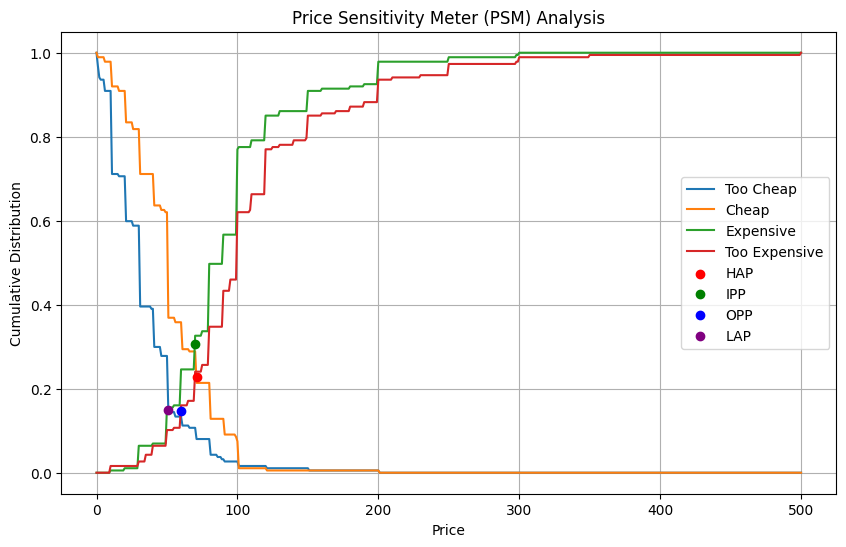

In [40]:
PSM(df,6)

IPP: 76
OPP: 60
HAP: 76
LAP: 51
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.005348        1.0            0.0
1        1       0.978610           0.005348        1.0            0.0
2        2       0.957219           0.005348        1.0            0.0
3        3       0.951872           0.005348        1.0            0.0
4        4       0.951872           0.005348        1.0            0.0
..     ...            ...                ...        ...            ...
396    396       0.000000           0.994652        0.0            1.0
397    397       0.000000           0.994652        0.0            1.0
398    398       0.000000           0.994652        0.0            1.0
399    399       0.000000           0.994652        0.0            1.0
400    400       0.000000           1.000000        0.0            1.0

[401 rows x 5 columns]


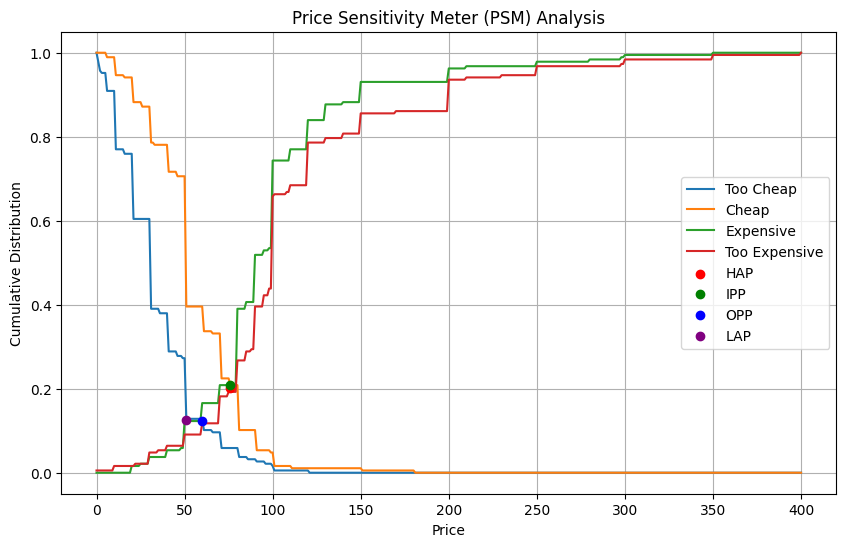

In [41]:
PSM(df,7)

IPP: 66
OPP: 51
HAP: 70
LAP: 51
     Price  Too_Cheap_CDF  Too_Expensive_CDF  Cheap_CDF  Expensive_CDF
0        0       1.000000           0.000000   1.000000            0.0
1        1       0.909091           0.000000   0.989305            0.0
2        2       0.877005           0.000000   0.989305            0.0
3        3       0.866310           0.000000   0.989305            0.0
4        4       0.860963           0.000000   0.989305            0.0
..     ...            ...                ...        ...            ...
346    346       0.000000           0.994652   0.000000            1.0
347    347       0.000000           0.994652   0.000000            1.0
348    348       0.000000           0.994652   0.000000            1.0
349    349       0.000000           0.994652   0.000000            1.0
350    350       0.000000           1.000000   0.000000            1.0

[351 rows x 5 columns]


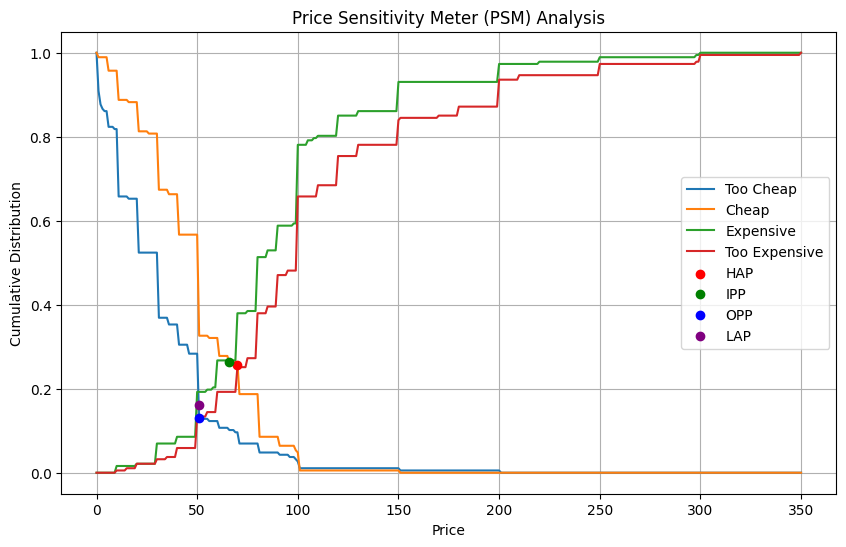

In [42]:
PSM(df,8)

In [44]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# データフレームの作成
data = pd.DataFrame({
    'A': [0, 1, 0, 1, 0, 1, 0, 1],
    'B': [0, 0, 1, 1, 0, 0, 1, 1],
    'C': [0, 0, 0, 0, 1, 1, 1, 1],
    'score': [100, 65.5, 68, 55.5, 60.5, 58.5, 65.5, 55.5]
})

# A, B, C をカテゴリカル変数として指定
data['A'] = data['A'].astype('category')
data['B'] = data['B'].astype('category')
data['C'] = data['C'].astype('category')

# ANOVAモデルの作成（交互作用を減らす）
model = ols('score ~ A + B + C', data=data).fit()

# ANOVA表の出力
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

           sum_sq   df         F    PR(>F)
A         435.125  1.0  3.270848  0.144791
B         200.000  1.0  1.503406  0.287394
C         300.125  1.0  2.256049  0.207505
Residual  532.125  4.0       NaN       NaN


In [26]:
# ANOVAモデルの作成（A×B×C以外の交互作用を含める）
model_interactions = ols('score ~ A * B + A * C + B * C', data=data).fit()

# ANOVA表の出力
anova_table_interactions = sm.stats.anova_lm(model_interactions, typ=2)
anova_table_interactions

,sum_sq,df,F,PR(>F)
A,427.78125,1.0,3.932491,0.297340
B,195.03125,1.0,1.792876,0.408374
C,318.78125,1.0,2.930480,0.336574
A:B,26.28125,1.0,0.241597,0.709163
A:C,157.53125,1.0,1.448147,0.441401
B:C,225.78125,1.0,2.075553,0.386280
Residual,108.78125,1.0,NaN,NaN
